# __LSTM-based prediction of the 2m air temperature data from the _Copernicus Climate Data Store_ (CDS)__ #

#### For this project, I used the 2m air temperature data from the ERA5 Reanalysis dataset (https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview) provided by the Copernicus Climate Data Store (CDS). ERA5 is a global climate reanalysis dataset that provides hourly estimates of atmospheric variables, including the 2m air temperature. $\\$ ####
#### The goal of this project is to build a simple LSTM neural network that can still perform reasonably well in predicting the mean temperature anomaly in Europe. The model is trained on data from 1940 to 2004 and evaluated on both the training data and the test data from 2005 to 2024. Different layer setups were tested to improve the model's performance. The results of the model's inference on both the training and test data are shown to give an idea of the lstm accuracy. Specifically, the training data is used to check if the model can reproduce the known patterns, while the test data is used to evaluate how well the model generalizes to unknown data. Finally, the trained network is used to predict future temperature anomalies. +++kommt noch+++

### __Creating the lstm neural network__

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
file = 'data_t2m_tot.nc' #2m air temperature
ds = xr.open_dataset(file, chunks = {'valid_time' : 50}) #chunks for faster computation
temp = ds.t2m 

C:\Users\teaca\AppData\Local\Temp\ipykernel_8908\1103566035.py:2: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(file, chunks = {'valid_time' : 50}) #chunks for faster computation


Define key parameters.

In [3]:
yrs = range(1940, 2025)
cutoff = 65 #year 2015
epochs = 100
patience = 25 #early stopping if no improvement after 25 epochs
baseline = 0.02, #early stopping if improvement stays below this threshold
start_epoch = 50 #wait 50 epochs before checking for early stopping
input_size = 5
batch_size = 4

In [4]:
temp_mean = temp.groupby(['valid_time.year']).mean(dim=['valid_time', 'latitude', 'longitude']) # (year)
anom_year = temp_mean - temp_mean.sel(year = 1940) #lazy compute yearly anomaly

In [5]:
anom_year_vals = anom_year.values[:-1] #extract values

Build the neural network. $\\$
The model uses an __LSTM neural network__, which is optimal for __time series data__ like the one used in this project. It consists of three LSTM layers with __up to 30 neurons__, which showed good performance during testing. There is a __dropout layer__ before the final layer to reduce the risk of overfitting. Although the dataset is relatively small, adding a low rate dropout layer gives an extra layer of caution and it also allows to estimate the uncertainty using __Monte Carlo dropout__, as mentioned below.

In [6]:
def build_lstm(input_size):
    model = Sequential()
    model.add(Input((input_size, 1)))
    model.add(LSTM(5, activation='relu', return_sequences=True))
    model.add(LSTM(15, activation='relu', return_sequences=True))
    model.add(Dropout(0.2)) #low dropout rate to prevent overfitting due to limited training data
    model.add(LSTM(30, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary() #summary fo the model
    return model

model_lstm = build_lstm(input_size)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 5)           │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 15)          │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 15)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30)             │         5,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,951 (27.15 KB)

 Trainable params: 6,951 (27.15 KB)

 Non-trainable params: 0 (0.00 B)

An __early stopping__ callback is defined to stop training once the model stops improving, as this helps save computation time and prevents overfitting by avoiding unnecessary epochs.

In [7]:
early_stopping = EarlyStopping(monitor = 'val_loss', #monitor the test error
                               patience = patience,
                               verbose = 1, #shows when callback is used
                               baseline = baseline,
                               restore_best_weights = True, #restore weights from the best performing epoch
                               start_from_epoch = start_epoch)

Define a function to prepare the input data, by splitting it into __overlapping sequences of fixed length__. For example, if given the list [1, 2, 3, 4, 5, 6] and an input size of 3, the function returns the input sequences [[1, 2, 3], [2, 3, 4], [3, 4, 5]], together with their corresponding output values [4, 5, 6].

In [8]:
def prep_data(data, input_size):
    x = np.zeros((len(data) - input_size, input_size))
    for i in range(len(x)):
        x[i] = data[i:i+input_size] #input darta
    y = np.array(data[input_size:]) #output data
    return x, y

Format the data and prepare it for training and testing.

In [9]:
#split data
training = anom_year_vals[:cutoff] 
test = anom_year_vals[cutoff - input_size:]  

#format into input-output pairs
x_train, y_train = prep_data(training, input_size)
x_test, y_test = prep_data(test, input_size)

Train the model.

In [10]:
fit_lstm = model_lstm.fit(x_train, y_train,
                        epochs=epochs,
                        validation_data=(x_test, y_test), #show error
                        callbacks=[early_stopping],
                        shuffle = False,
                        batch_size = batch_size)

res_test = model_lstm.predict(x_test, verbose=0).flatten()
res_train = model_lstm.predict(x_train, verbose=0).flatten()

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.7839 - val_loss: 4.3040
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6634 - val_loss: 3.8061
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5031 - val_loss: 2.8928
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2761 - val_loss: 1.2873
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1165 - val_loss: 0.2957
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1769 - val_loss: 0.5295
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1434 - val_loss: 0.5713
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1305 - val_loss: 0.4233
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1456 - val_loss: 0.3851
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1355 - val_loss: 0.3457
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1393 - val_loss: 0.3758
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Plot the training and validation (test) loss. $\\$

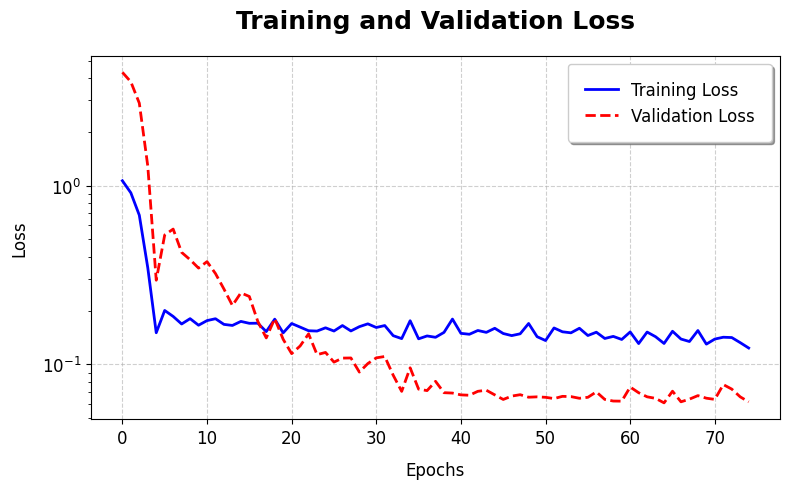

In [11]:
plt.figure(figsize=(8, 5))

#plot training and test loss
plt.plot(fit_lstm.history['loss'], color='blue', linewidth=2, label="Training Loss")
plt.plot(fit_lstm.history['val_loss'], color='red', linewidth=2, linestyle='--', label="Validation Loss")
plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize=12,  labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.title('Training and Validation Loss', fontsize=18, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='best', fontsize=12, frameon=True, fancybox=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.savefig('lstm_accuracy.png')
plt.show()

The training loss decreases quickly already after a few epochs, indicating that __the model is learning fast__. However, even if the validation loss takes longer to decrease, it eventually falls below the training loss after several more epochs. This could be for different reasons, one being the nature of the data. Indeed the validation data, which spans from 2005 on, is __slightly smoother__, it has fewer fluctuations compared to the training data, which in contrary has more steep peaks. As a result, the model probably finds it easier to learn from the validation data. Additionally, the __dropout layer__ is active during training but not during validation, as standard in Keras, which could also explain the difference of accuracy. The y axis of the plot is logarithmically scaled to better visualize the results. $\\$
Despite these differences, both the training and validation losses ultimately reach a __sufficiently small error__, showing that the model is __performing well__ on both datasets.


Define the __Monte Carlo dropout__ function following _Gal & Ghahramani (2015)_ (https://arxiv.org/abs/1506.02142) to estimate the uncertainty of the model. The MC dropout keeps the __dropout layer active during inference__, instead of only during training. Then, by performing multiple forward passes with the same input, the MC dropout generates a __distribution of outputs__. The mean corresponds to the final prediction, while the variance reflects the model’s confidence. $\\$
Also define an __exponential fit__ to model the warming trend in the temperature anomaly. This is used to compare between the neural network's predictions and the __overall trend__, checking if the model captures the exponential nature of the warming over time.



In [12]:
def MC_dropout(model, X, n):
    preds = np.array([model(X, training=True) for i in range(n)])
    mean_preds = preds.mean(axis=0)
    var = preds.var(axis=0)
    return mean_preds.flatten(), var.flatten()

def exp_fit(x, a, b, c):
    return a*np.exp(b * x) + c

Define more key parameters for plotting.

In [13]:
x_fit = np.array(yrs) - 1940  #shift years to start from 0
#split the x axis in training and test
x_train_ax = range(input_size, len(res_train)+input_size)
x_test_ax = range(len(res_train)+input_size, len(res_train)+input_size+ len(res_test))

In [14]:
n_MC = 100 #forward passes
mean_preds_train, var_train = MC_dropout(model_lstm, x_train, n_MC)
mean_preds_test, var_test = MC_dropout(model_lstm, x_test, n_MC)
std_dev_test = np.sqrt(var_test)  
std_dev_train = np.sqrt(var_train)

params, _ = curve_fit(exp_fit, x_fit, anom_year_vals, p0= [1, 0.001, 0])
fit_data = exp_fit(x_fit, *params)

Display the results in a __line plot__. $\\$
This plot shows the __neural network's predictions__ together with the __actual temperature anomalies__. The black line represents the observed temperature anomalies, while the blue line shows the exponential fit. The green and light blue lines represent the inference results of the model for the training resp. test data. The red and orange lines show the results of the MC dropout, here taken as the mean of 100 forward passes. The uncertainty associated with the MC dropout predictions is represented by the shaded regions in light red and light orange, representing the __regions of uncertainty__.

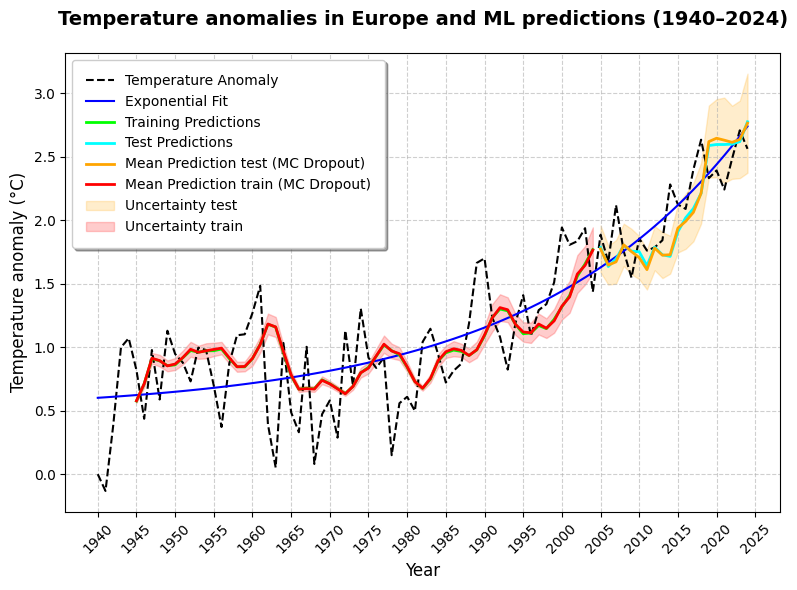

In [15]:
plt.figure(figsize=(8, 6))

plt.plot(range(0, len(anom_year_vals)), anom_year_vals, linestyle='--', color='black', label='Temperature Anomaly', linewidth = 1.5)
plt.plot(fit_data, color='blue', linewidth=1.5, label='Exponential Fit')
plt.plot(x_train_ax, res_train, color='lime', linewidth=2, label='Training Predictions')
plt.plot(x_test_ax, res_test, color='aqua', linewidth=2, label='Test Predictions')
plt.plot(x_test_ax, mean_preds_test, color='orange', linewidth=2, label="Mean Prediction test (MC Dropout)")
plt.plot(x_train_ax, mean_preds_train, color='red', linewidth=2, label="Mean Prediction train (MC Dropout)")

#MC dropout uncertainty
plt.fill_between(x_test_ax, mean_preds_test+std_dev_test, mean_preds_test-std_dev_test, color='orange', alpha=0.2, label='Uncertainty test')
plt.fill_between(x_train_ax, mean_preds_train+std_dev_train, mean_preds_train-std_dev_train, color='red', alpha=0.2, label='Uncertainty train')

year_ticks = np.arange(1940, 2026, 5)
plt.xticks(year_ticks - 1940, year_ticks, fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature anomaly (°C)', fontsize=12)
plt.title('Temperature anomalies in Europe and ML predictions (1940–2024)', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.savefig('lstm_temp_comparison.png')
plt.show()

#### The plot shows that the __mean predictions from MC dropout__, in red and orange, __closely match the original model predictions__, in green and light blue, and are almost overlapping. This is due to the low dropout rate of 0.2, so that the variation across different runs stays small.$\\$
#### When comparing the MC uncertainty for inputs from the training period and the validation period, the difference is clear. For inputs from the earlier years, data the model has already seen during training, the __uncertainty remains low__, showing that the __model is confident with known patterns__. But in the test period, especially from year 2018 to 2024, the __uncertainty grows significantly__. This is expected, since when the model makes predictions with unknown data, it becomes less certain, a __common behavior in time series models__, where small differences can accumulate over time. Despite this, both the model’s predictions and the MC dropout mean __follow the overall trend__ of the observed temperature anomalies and match the exponential trend quite well within uncertainty range. In summary, the plot shows that even a __simple LSTM neural network__ can do a good job at __reproducing the trend of rising temperatures across Europe__, following the exponential pattern quite clearly.